In [1]:
import os
import sys
from dotenv import load_dotenv

notebook_path = os.getcwd()

# One level up from the notebook
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_path, "../"))

DATA_ROOT = os.path.join(PROJECT_ROOT, "data")

sys.path.insert(1, PROJECT_ROOT)
load_dotenv()

True

In [2]:
import glob

import databento as db
import pandas as pd
import numpy as np
import datetime

import plotly.graph_objects as go

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import re

Load saved Options price OHLCV and aggregate

In [64]:
symbol = "TSLA"
df = pd.read_csv(os.path.join(DATA_ROOT, "databento", f"{symbol}-options-ohlcv-1d.csv"), index_col=0)

df.index = pd.to_datetime(df.index, utc=True)
df['expiry_date'] = pd.to_datetime(df['expiry_date'], utc=True)

In [65]:
df.head()

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol_base,expiry_date,type,strike
ts_event,,,,,,,,,,,,
2023-03-28 00:00:00+00:00,35,32,687866457,59.70,59.70,59.70,59.70,1,TSLA,2025-01-17 00:00:00+00:00,C,195.0
2023-03-28 00:00:00+00:00,35,34,687865924,23.81,23.81,22.40,22.40,2,TSLA,2025-01-17 00:00:00+00:00,C,350.0
2023-03-28 00:00:00+00:00,35,24,687865981,2.07,2.07,1.75,1.89,10,TSLA,2023-05-19 00:00:00+00:00,C,260.0
2023-03-28 00:00:00+00:00,35,28,687865981,2.04,2.04,1.73,1.73,4,TSLA,2023-05-19 00:00:00+00:00,C,260.0
2023-03-28 00:00:00+00:00,35,24,687866668,1.03,1.03,0.90,0.92,7,TSLA,2023-05-19 00:00:00+00:00,C,285.0


Load saved Stock price OHLCV and aggregate

In [66]:
def read_df_with_prefix(directory, prefix):
    tmp = []

    for filename in glob.glob(os.path.join(directory, f"{prefix}*")):
        tmp.append(pd.read_csv(filename, index_col=0))

    return pd.concat(tmp, axis=0)

timeframe = "1d"

directory = os.path.join(DATA_ROOT, "databento")
prefix = f"{symbol.upper()}_ohlcv-1m_"

stock_df = read_df_with_prefix(directory, prefix)
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df[['open','high','low','close','volume']]

start_time = '14:30'
end_time = '21:00'

agg_methods = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
}

tmp = stock_df.resample("1d").agg(agg_methods)
tmp = tmp.dropna() # non-trading days are na
trading_days = tmp.index

resampled_stock_df = stock_df.between_time(start_time, end_time).resample(timeframe).agg(agg_methods)
# aggregation creates non-trading dates. line below eliminates them.
resampled_stock_df = resampled_stock_df.loc[resampled_stock_df.index.strftime("%Y-%m-%d").isin(trading_days.strftime("%Y-%m-%d"))]

In [67]:
resampled_stock_df.loc['2024-01-01':'2024-01-07']

,open,high,low,close,volume
ts_event,,,,,
2024-01-02 00:00:00+00:00,250.15,251.25,244.42,248.38,13057598
2024-01-03 00:00:00+00:00,245.00,245.67,236.32,238.37,13550222
2024-01-04 00:00:00+00:00,239.16,242.69,237.73,237.89,11378683
2024-01-05 00:00:00+00:00,236.86,240.11,235.00,237.45,9670475


for option data aggregation below, may consider volume weighted mean for OHLC. but simple mean for now...

note: option need agg b/c even for one symbol, there are multiple data sources (see publisher csv)

In [68]:
agg_df = df[['type', 'strike', 'expiry_date', 'open', 'high', 'low', 'close', 'volume']].groupby(
    ['ts_event', 'type', 'strike', 'expiry_date']).agg({
        'open': 'mean',
        'high': 'mean',
        'low': 'mean',
        'close': 'mean',
        'volume': 'sum'
    })

tmp = []
for mi in agg_df.index:
    tmp.append(mi[3]-mi[0])

agg_df['time_to_expiry'] = tmp

agg_df = agg_df[:'2024-12-31'] # cut here bc stock data stops on 12/31/24

Load risk free rate data

In [71]:
rates_df = pd.read_csv(os.path.join(DATA_ROOT, 'rates.csv'))
rates_df['Effective Date'] = pd.to_datetime(rates_df['Effective Date'], utc=True)

In [72]:
rates_df

,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
0,2025-02-04 00:00:00+00:00,EFFR,4.33,4.31,4.33,4.34,4.40,104.0,4.25,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-04 00:00:00+00:00,OBFR,4.33,4.25,4.33,4.33,4.40,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-04 00:00:00+00:00,TGCR,4.31,4.26,4.31,4.32,4.36,894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-04 00:00:00+00:00,BGCR,4.31,4.26,4.31,4.32,4.38,909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-04 00:00:00+00:00,SOFR,4.33,4.28,4.32,4.38,4.42,2344.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,2000-07-07 00:00:00+00:00,EFFR,6.42,NaN,NaN,NaN,NaN,NaN,6.50,NaN,6.00,6.75,0.12,NaN,NaN,NaN,NaN,NaN,NaN
13551,2000-07-06 00:00:00+00:00,EFFR,6.51,NaN,NaN,NaN,NaN,NaN,6.50,NaN,6.25,8.00,0.13,NaN,NaN,NaN,NaN,NaN,NaN
13552,2000-07-05 00:00:00+00:00,EFFR,6.52,NaN,NaN,NaN,NaN,NaN,6.50,NaN,2.00,6.94,0.50,NaN,NaN,NaN,NaN,NaN,NaN
13553,2000-07-03 00:00:00+00:00,EFFR,7.03,NaN,NaN,NaN,NaN,NaN,6.50,NaN,5.50,7.50,0.28,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Effective Date'>

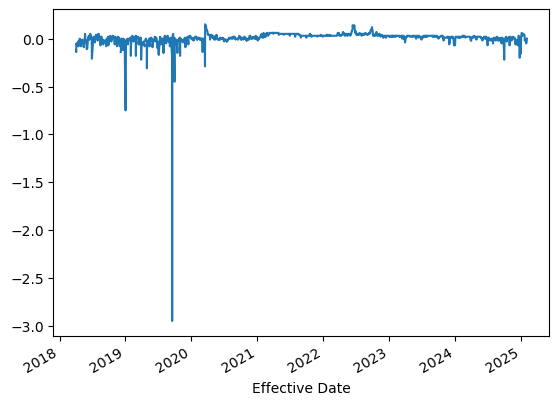

In [51]:
# SOFR starts in 2018 March. EFFR seems close enough for data before that.
dif = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR', 'Rate (%)'] - rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
dif.plot()

In [73]:
sofr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
switch_day = sofr_rates.index[0]
effr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR'].loc[:switch_day - pd.Timedelta(days=1), 'Rate (%)']

In [74]:
risk_frees: pd.Series = pd.concat([effr_rates, sofr_rates])
dt = pd.date_range(risk_frees.index.min(), risk_frees.index.max(), freq='D')

rf_df = pd.DataFrame(index=dt, data=risk_frees)
rf_df['Rate (%)'] = rf_df['Rate (%)'].ffill()

merge stock price into option `agg_df`

In [ ]:
firsts = agg_df.index.get_level_values('ts_event')
agg_df.loc[:, 'stock_close'] = resampled_stock_df.loc[firsts, 'close'].values
agg_df.loc[:, 'risk_free'] = (rf_df.loc[firsts, 'Rate (%)'] / 100).values
agg_df['time_to_expiry'] = agg_df['time_to_expiry'].apply(lambda x: x.days/365) # pd.Timedelta to number of years (float)

In [77]:
agg_df.head(20)

open  \
ts_event                  type strike expiry_date                         
2023-03-28 00:00:00+00:00 C    1.67   2023-09-15 00:00:00+00:00  186.75   
                                      2024-01-19 00:00:00+00:00  187.24   
                               5.00   2023-09-15 00:00:00+00:00  184.00   
                                      2024-01-19 00:00:00+00:00  181.00   
                               18.33  2023-06-16 00:00:00+00:00  168.30   
                               20.00  2023-04-14 00:00:00+00:00  167.65   
                                      2024-01-19 00:00:00+00:00  168.93   
                               30.00  2023-04-28 00:00:00+00:00  158.88   
                                      2025-12-19 00:00:00+00:00  165.00   
                               35.00  2025-06-20 00:00:00+00:00  159.40   
                               45.00  2025-01-17 00:00:00+00:00  148.60   
                               50.00  2023-03-31 00:00:00+00:00  139.35   
                                      2023-04-06 00:00:00+00:00  139.39   
                                      2023-04-21 00:00:00+00:00  139.10   
                                      2023-06-16 00:00:00+00:00  139.53   
                                      2023-07-21 00:00:00+00:00  140.24   
                                      2023-12-15 00:00:00+00:00  140.50   
                                      2025-01-17 00:00:00+00:00  145.11   
                               55.00  2024-06-21 00:00:00+00:00  139.95   
                               60.00  2023-03-31 00:00:00+00:00  131.48   

                                                                   high  \
ts_event                  type strike expiry_date                         
2023-03-28 00:00:00+00:00 C    1.67   2023-09-15 00:00:00+00:00  186.75   
                                      2024-01-19 00:00:00+00:00  187.24   
                               5.00   2023-09-15 00:00:00+00:00  184.00   
                                      2024-01-19 00:00:00+00:00  182.60   
                               18.33  2023-06-16 00:00:00+00:00  168.30   
                               20.00  2023-04-14 00:00:00+00:00  167.65   
                                      2024-01-19 00:00:00+00:00  168.93   
                               30.00  2023-04-28 00:00:00+00:00  159.00   
                                      2025-12-19 00:00:00+00:00  165.00   
                               35.00  2025-06-20 00:00:00+00:00  159.40   
                               45.00  2025-01-17 00:00:00+00:00  148.60   
                               50.00  2023-03-31 00:00:00+00:00  139.35   
                                      2023-04-06 00:00:00+00:00  139.39   
                                      2023-04-21 00:00:00+00:00  139.10   
                                      2023-06-16 00:00:00+00:00  139.53   
                                      2023-07-21 00:00:00+00:00  140.24   
                                      2023-12-15 00:00:00+00:00  140.50   
                                      2025-01-17 00:00:00+00:00  145.11   
                               55.00  2024-06-21 00:00:00+00:00  139.95   
                               60.00  2023-03-31 00:00:00+00:00  131.48   

                                                                    low  \
ts_event                  type strike expiry_date                         
2023-03-28 00:00:00+00:00 C    1.67   2023-09-15 00:00:00+00:00  186.75   
                                      2024-01-19 00:00:00+00:00  184.65   
                               5.00   2023-09-15 00:00:00+00:00  184.00   
                                      2024-01-19 00:00:00+00:00  181.00   
                               18.33  2023-06-16 00:00:00+00:00  168.30   
                               20.00  2023-04-14 00:00:00+00:00  167.65   
                                      2024-01-19 00:00:00+00:00  168.93   
                               30.00  2023-04-28 00:00:00+00:00  158.88   
               

In [78]:
agg_df = agg_df[['close', 'stock_close', 'time_to_expiry', 'risk_free']].rename(columns={'close': 'option_close'})
agg_df = agg_df.reset_index()

In [79]:
agg_df.head(5)

,ts_event,type,strike,expiry_date,option_close,stock_close,time_to_expiry,risk_free
0,2023-03-28 00:00:00+00:00,C,1.67,2023-09-15 00:00:00+00:00,186.75,189.63,0.468493,0.0484
1,2023-03-28 00:00:00+00:00,C,1.67,2024-01-19 00:00:00+00:00,184.65,189.63,0.813699,0.0484
2,2023-03-28 00:00:00+00:00,C,5.00,2023-09-15 00:00:00+00:00,184.00,189.63,0.468493,0.0484
3,2023-03-28 00:00:00+00:00,C,5.00,2024-01-19 00:00:00+00:00,182.60,189.63,0.813699,0.0484
4,2023-03-28 00:00:00+00:00,C,18.33,2023-06-16 00:00:00+00:00,168.30,189.63,0.219178,0.0484


In [80]:
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

In [59]:
def implied_vol(S0, K, T, r, market_price, flag='C', tol=0.00001):
    max_iter = 200 #max number of iterations
    vol_old = 0.30 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag.lower(), S0, K, T, r, vol_old)
        Cprime   = vega(flag.lower(), S0, K, T, r, vol_old) * 100
        if np.isnan(vol_old): break
        # print(k, vol_old, Cprime)
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        bs_new = bs(flag.lower(), S0, K, T, r, vol_new)

        if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
            break
        vol_old = vol_new

    implied_vol = vol_old
    return implied_vol

In [60]:
# test if the function works
S0, K, T, r = 30, 28, 0.2, 0.025
market_price = 3.97
implied_vol_est = implied_vol(S0, K, T, r, market_price, flag='C')
print(f"Implied Volatility = {implied_vol_est:.3%}")

Implied Volatility = 53.816%


In [81]:
agg_df['implied_volatility'] = agg_df.apply(lambda row: implied_vol(
        S0=row['stock_close'],
        K=row['strike'],
        T=row['time_to_expiry'],
        r=row['risk_free'],  # Get risk-free rate by expiry date
        market_price=row['option_close'],
        flag=row['type']
), axis=1)

C:\Users\Austin\AppData\Local\Temp\ipykernel_60252\493353802.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  vol_new = vol_old - C/Cprime
C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\py_vollib\ref_python\black_scholes\__init__.py:87: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator
C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\py_vollib\ref_python\black_scholes\__init__.py:81: RuntimeWarning: overflow encountered in scalar multiply
  sigma_squared = sigma * sigma
C:\Users\Austin\AppData\Local\Temp\ipykernel_60252\493353802.py:11: RuntimeWarning: overflow encountered in scalar divide
  vol_new = vol_old - C/Cprime


C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\py_vollib\ref_python\black_scholes\__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\py_vollib\ref_python\black_scholes\__init__.py:82: RuntimeWarning: invalid value encountered in scalar multiply
  numerator = numpy.log(S / float(K)) + (r + sigma_squared / 2.) * t
C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\py_vollib\ref_python\black_scholes\__init__.py:83: RuntimeWarning: invalid value encountered in scalar multiply
  denominator = sigma * numpy.sqrt(t)


C:\Users\Austin\AppData\Local\Temp\ipykernel_60252\493353802.py:11: RuntimeWarning: invalid value encountered in scalar divide
  vol_new = vol_old - C/Cprime


In [62]:
agg_df

,ts_event,type,strike,expiry_date,option_close,stock_close,time_to_expiry,risk_free,implied_volatility
0,2023-03-28 00:00:00+00:00,C,5.0,2023-06-16 00:00:00+00:00,257.550,263.95,0.219178,0.0484,NaN
1,2023-03-28 00:00:00+00:00,C,5.0,2024-06-21 00:00:00+00:00,258.275,263.95,1.235616,0.0484,NaN
2,2023-03-28 00:00:00+00:00,C,15.0,2024-06-21 00:00:00+00:00,247.760,263.95,1.235616,0.0484,NaN
3,2023-03-28 00:00:00+00:00,C,70.0,2023-03-31 00:00:00+00:00,191.310,263.95,0.008219,0.0484,NaN
4,2023-03-28 00:00:00+00:00,C,75.0,2023-03-31 00:00:00+00:00,187.800,263.95,0.008219,0.0484,NaN
...,...,...,...,...,...,...,...,...,...
1383565,2024-12-31 00:00:00+00:00,P,270.0,2027-01-15 00:00:00+00:00,135.790,134.50,2.041096,0.0449,0.639252
1383566,2024-12-31 00:00:00+00:00,P,280.0,2027-01-15 00:00:00+00:00,145.070,134.50,2.041096,0.0449,0.657678
1383567,2024-12-31 00:00:00+00:00,P,290.0,2025-03-21 00:00:00+00:00,154.300,134.50,0.219178,0.0449,NaN
1383568,2024-12-31 00:00:00+00:00,P,290.0,2025-04-17 00:00:00+00:00,155.700,134.50,0.293151,0.0449,NaN


In [63]:
agg_df.to_csv(os.path.join(DATA_ROOT, "option_iv", f"{symbol}-iv-1d.csv"))